# Heat Wave Change Maps
* Map of percent of HW days that are compound in present climate.
* Map of percent of HW days that are compound in future climate.
* Scatter plot of percent compound in present versus future with 1-1 line.

In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
#Import CDO and make sure it works
from cdo import *

#--Initialize CDO
cdo=Cdo()

%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import matplotlib.colors as colors
import collections

os.chdir('/home/jwb/')

In [13]:
#Correlation Calculation for Many Definitions
corr = collections.defaultdict(dict)
xns = ['n','x']
days = ['1112','1212','1312','3114','3136','3214','3236','3314','3336','6117','61612','6217','62612','63612']
pctns = ['90','95']

for defxn in xns:
    for defday in days:
        for pctn in pctns:

            files = {'Control':'t'+defxn+pctn+'pct_heatwaves_FLOR_Control_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc',
            'XYTave':'t'+defxn+pctn+'pct_heatwaves_FLOR_XYTave_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc',
            '2xCO2':'t'+defxn+pctn+'pct_heatwaves_FLOR_2XCO2_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc'}

            head = files['Control'][0:7]

            ahwf0 = {}
            ahwf = {}
            ahw2f = {}
            cp = {}
            cp_diff = {}
    
            for key, value in files.iteritems():
                ahwf0[key] = cdo.timmean(input = '-selvar,%s %s' %('AHWF_'+head,value),output = key+'_ahwf_'+defday+defxn+pctn+'.nc',
                               options='-f nc', returnCdf=True)
                ahw2f[key] = cdo.timmean(input = '-selvar,%s %s' %('AHW2F_'+head,value),output = key+'_ahw2f_'+defday+defxn+pctn+'.nc',
                               options='-f nc', returnCdf=True)
                cp[key] = cdo.mulc(100,input = '-div %s %s' %(key+'_ahw2f_'+defday+defxn+pctn+'.nc',key+'_ahwf_'+defday+defxn+pctn+'.nc'), 
                           output = key+'_cp_'+defday+defxn+pctn+'.nc',options='-f nc', returnCdf=True) 

            for key in ['2xCO2','XYTave']:
                cp_diff[key] = cdo.sub(input = '%s %s' %(key+'_cp_'+defday+defxn+pctn+'.nc','Control_cp_'+defday+defxn+pctn+'.nc'), 
                               output = key+'_cp_diff_'+defday+defxn+pctn+'.nc',options='-f nc', returnCdf=True)
    
            regions = {'All':[-180,180,-90,90],'CONUS':[-125,-65,20,50],'Western Europe':[-10,40,40,60],'Australia':[113,154,-39,-10],
               'Greenland':[-71,-11,57,83],'East Asia':[95,146,20,46],'India':[68,90,7,35],'Brazil':[-34,-73,-33,4],
               'Sub-Saharan Africa':[-18,50,-33,23]}

            for key, value in regions.iteritems():
                corr[defday+defxn+pctn][key] = cdo.fldcor(input = '-sellonlatbox,%s,%s,%s,%s %s -sellonlatbox,%s,%s,%s,%s %s' %(value[0],value[1],value[2],value[3],'2xCO2_cp_diff_'+defday+defxn+pctn+'.nc',value[0],value[1],value[2],value[3],'XYTave_cp_diff_'+defday+defxn+pctn+'.nc'),options='-f nc',returnCdf=True)
                corr[defday+defxn+pctn][key] = np.squeeze(corr[defday+defxn+pctn][key]['AHW2F_'+head][:])

In [7]:
#Analysis for Maps
defxn = 'n'
defday = '3114'
pctn = '90'

files = {'Control':'t'+defxn+pctn+'pct_heatwaves_FLOR_Control_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc',
        'XYTave':'t'+defxn+pctn+'pct_heatwaves_FLOR_XYTave_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc',
        '2xCO2':'t'+defxn+pctn+'pct_heatwaves_FLOR_2XCO2_'+pctn+'pct_400yr_rNone_'+defday+'_yearly_summer.nc'}

head = files['Control'][0:7]

ahwf0 = {}
ahwf = {}
ahw2f = {}
cp = {}
cp_diff = {}
ahwfp = {}

for key, value in files.iteritems():
    ahwf0[key] = cdo.timmean(input = '-selvar,%s %s' %('AHWF_'+head,value),output = key+'_ahwf_'+defday+defxn+pctn+'.nc',
                           options='-f nc', returnCdf=True)
    ahwf[key] = np.squeeze(ahwf0[key]['AHWF_'+head][:])
    ahw2f[key] = cdo.timmean(input = '-selvar,%s %s' %('AHW2F_'+head,value),output = key+'_ahw2f_'+defday+defxn+pctn+'.nc',
                           options='-f nc', returnCdf=True)
    ahw2f[key] = np.squeeze(ahw2f[key]['AHW2F_'+head][:])
    cp[key] = cdo.mulc(100,input = '-div %s %s' %(key+'_ahw2f_'+defday+defxn+pctn+'.nc',key+'_ahwf_'+defday+defxn+pctn+'.nc'), 
                       output = key+'_cp_'+defday+defxn+pctn+'.nc',options='-f nc', returnCdf=True) 
    cp[key] = np.squeeze(cp[key]['AHW2F_'+head][:])
    ahwfp[key] = ahwf[key]/153*100

for key in ['2xCO2','XYTave']:
    cp_diff[key] = cdo.sub(input = '%s %s' %(key+'_cp_'+defday+defxn+pctn+'.nc','Control_cp_'+defday+defxn+pctn+'.nc'), 
                           output = key+'_cp_diff_'+defday+defxn+pctn+'.nc',options='-f nc', returnCdf=True)
    cp_diff[key] = np.squeeze(cp_diff[key]['AHW2F_'+head][:])
    
lats0 = ahwf0['2xCO2']['lat'][:]
lons0 = ahwf0['2xCO2']['lon'][:]

In [8]:
#Calculates means

lat_s = -90
lat_n = 90
lon_w = 0
lon_e = 360

mlats = np.transpose(np.tile(lats0,(lons0.shape[0],1)))
weights = np.cos(np.deg2rad(mlats))
mlons = np.tile(lons0,(lats0.shape[0],1))
lats_mask = np.logical_and(mlats >= lat_s, mlats <= lat_n)
lons_mask = np.logical_and(mlons >= lon_w, mlons <= lon_e)
reg_mask = lats_mask*lons_mask

def spacemean(var):
    regmean = np.ma.average(var[reg_mask], weights = weights[reg_mask])
    return regmean

lat_0 = lats0.mean()
lon_0 =  lons0.mean()

parallels = np.arange(-90.,90,30.)
meridians = np.arange(0.,360.,60.)

In [9]:
#Define function to draw boxes on maps over specific regions
color = 'b'
def mapbox(reg):
    lon1 = reg[0]
    lon2 = reg[1]
    lat1 = reg[2]
    lat2 = reg[3]
    m.drawgreatcircle(lon1,lat2,lon2,lat2,linewidth=2,color=color,linestyle='--')
    m.drawgreatcircle(lon2,lat2,lon2,lat1,linewidth=2,color=color,linestyle='--')
    m.drawgreatcircle(lon2,lat1,lon1,lat1,linewidth=2,color=color,linestyle='--')
    m.drawgreatcircle(lon1,lat1,lon1,lat2,linewidth=2,color=color,linestyle='--')

In [14]:
#Define regions (if not run in third cell)
regions = {'All':[-180,180,-90,90],'CONUS':[-125,-65,20,50],'Western Europe':[-10,40,40,60],'Australia':[113,154,-39,-10],
               'Greenland':[-71,-11,57,83],'East Asia':[95,146,20,46],'India':[68,90,7,35],'Brazil':[-34,-73,-33,4],
               'Sub-Saharan Africa':[-18,50,-33,23]}

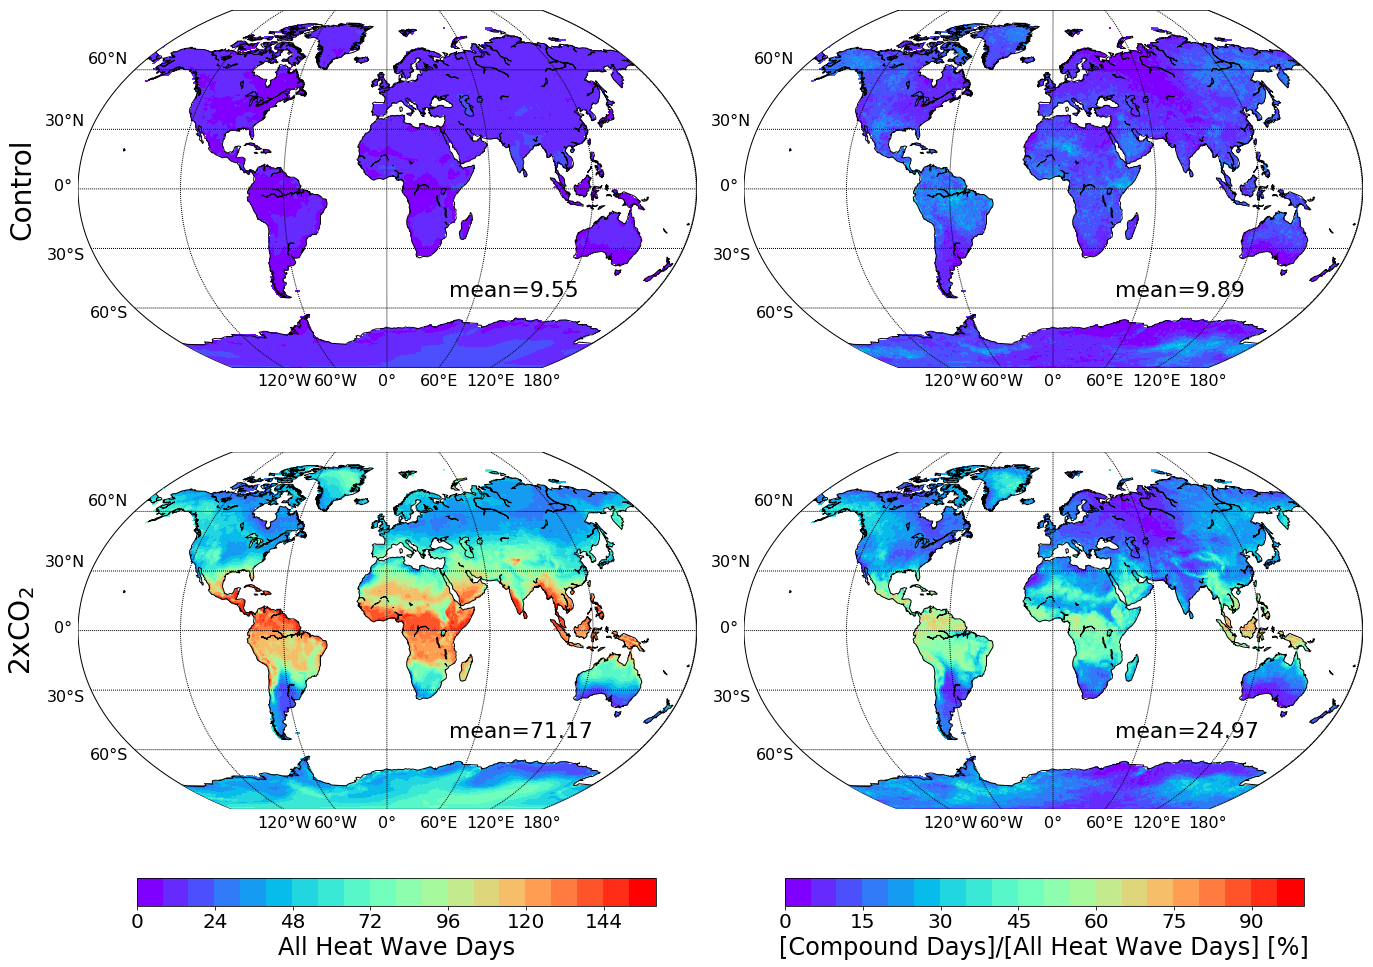

In [12]:
#Mean Maps
fig = plt.figure(figsize=(18,13))

fs = 16

start = lons0[0]
y1 = -90
y2 = 90
sf = 180
x1 = start+sf
lon0 = start+180+sf

ax1 = plt.subplot(2,2,1)
var = ahwf['Control']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
xi, yi = m(lon, lat)
bounds=np.linspace(0,160,21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=plt.cm.rainbow)
ax1.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax1.transAxes,fontsize=22)

ax3 = plt.subplot(2,2,3)
var = ahwf['2xCO2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
bounds=np.linspace(0,160,21) #np.linspace(0,160,21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=plt.cm.rainbow)
ax3.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax3.transAxes,fontsize=22)

ax2 = plt.subplot(2,2,2)
var = cp['Control']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
bounds=np.linspace(0,100,21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
csp = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=plt.cm.rainbow)
ax2.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax2.transAxes,fontsize=22)

ax4 = plt.subplot(2,2,4)
var = cp['2xCO2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
bounds=np.linspace(0,100,21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
csp = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=plt.cm.rainbow)
ax4.text(.6, .2, 'mean=%.2f'%spacemean(var), transform=ax4.transAxes,fontsize=22)

ax1.text(-0.09,0.5, "Control", transform=ax1.transAxes, fontsize=28, rotation='vertical',ha='center',va='center')
ax3.text(-0.09,0.5, "2xCO$_{2}$", transform=ax3.transAxes, fontsize=28, rotation='vertical',ha='center',va='center')

#ax1.text(0.93,0.9, "a", transform=ax1.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            #fc='0.8', alpha=1.0), zorder=100)
#ax2.text(0.93,0.9, "b", transform=ax2.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            #fc='0.8', alpha=1.0), zorder=100)
#ax3.text(0.93,0.9, "c", transform=ax3.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            #fc='0.8', alpha=1.0), zorder=100)
#ax4.text(0.93,0.9, "d", transform=ax4.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            #fc='0.8', alpha=1.0), zorder=100)

cax = fig.add_axes([0.05, -0.03, 0.4, 0.03])
art = plt.colorbar(cs, cax, orientation='horizontal')
art.set_label('All Heat Wave Days', fontsize=24)
art.ax.tick_params(labelsize=20)
caxp = fig.add_axes([0.55, -0.03, 0.4, 0.03])
art2 = plt.colorbar(csp, caxp, orientation='horizontal')
art2.set_label('[Compound Days]/[All Heat Wave Days] [%]', fontsize=24)
art2.ax.tick_params(labelsize=20)

plt.tight_layout(pad=0.2, w_pad=4, h_pad=0.2)

fig.savefig(defxn+defday+pctn+'_mean.pdf',bbox_inches='tight')

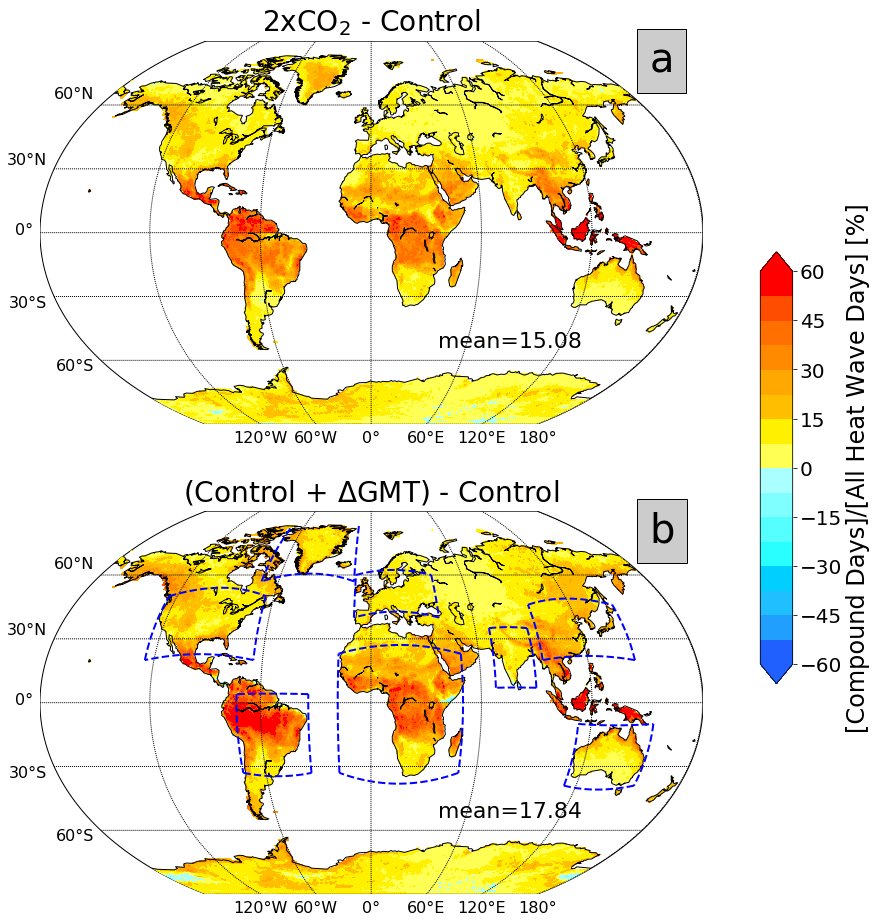

In [15]:
#Difference Maps
fig = plt.figure(figsize=(18,12))

fs = 16

start = lons0[0]
y1 = -90
y2 = 90
sf = 180
x1 = start+sf
lon0 = start+180+sf

ax1 = plt.subplot(2,1,1)
var = cp_diff['2xCO2']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
xi, yi = m(lon, lat)
bounds=np.linspace(-60,60,17)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cm.GMT_no_green,extend='both')
ax1.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax1.transAxes,fontsize=22)
#for reg in ['CONUS','Western Europe','Australia',
           #'Greenland','East Asia','India','Brazil',
           #'Sub-Saharan Africa']:
    #mapbox(regions[reg])

ax2 = plt.subplot(2,1,2)
var = cp_diff['XYTave']
shift, lons = shiftgrid(x1,var,lons0,start=True,cyclic=360.0)
lon, lat = np.meshgrid(lons, lats0)
m = Basemap(projection='kav7',lon_0=lon0,resolution='c') #lon_0=180
m.drawmapboundary(fill_color='white')
m.drawcoastlines() # draw coast line
# draw parallels.
parallels = np.arange(-90.,90,30.)
m.drawparallels(parallels,labels=[1,0,0,0],fontsize=fs)
# draw meridians
meridians = np.arange(0.,360.,60.)
m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=fs)
bounds=np.linspace(-60,60,17)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cs = m.contourf(xi,yi,shift,bounds,norm=norm,cmap=cm.GMT_no_green,extend='both')
ax2.text(.6, .2, 'mean=%.2f'%spacemean(var),transform=ax2.transAxes,fontsize=22)
for reg in ['CONUS','Western Europe','Australia',
           'Greenland','East Asia','India','Brazil',
           'Sub-Saharan Africa']:
    mapbox(regions[reg])

ax1.text(0.5,1.05, "2xCO$_{2}$ - Control", transform=ax1.transAxes, fontsize=28, rotation='horizontal',ha='center',va='center')
ax2.text(0.5,1.05, "(Control + $\Delta$GMT) - Control", transform=ax2.transAxes, fontsize=28, rotation='horizontal',ha='center',va='center')

ax1.text(0.919,0.919, "a", transform=ax1.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)
ax2.text(0.919,0.919, "b", transform=ax2.transAxes, fontsize=40, bbox=dict(boxstyle='square',
            fc='0.8', alpha=1.0), zorder=100)

cax = fig.add_axes([0.8, 0.25, 0.025, 0.5])
art = plt.colorbar(cs, cax, orientation='vertical')
art.set_label('[Compound Days]/[All Heat Wave Days] [%]', fontsize=24)
art.ax.tick_params(labelsize=20)

plt.tight_layout(pad=0.2, w_pad=2.5, h_pad=8)

fig.savefig(defxn+defday+pctn+'_diff.pdf', bbox_inches='tight')

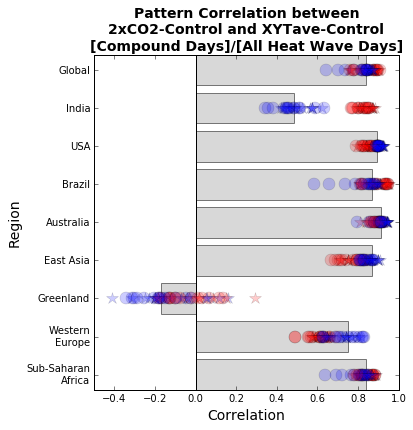

In [15]:
#Bar chart of pattern correlations
for key, value in corr.iteritems():
    corr[key] = collections.OrderedDict(sorted(corr[key].items(), key=lambda t: len(t[0])))

fs = 10 #fontsize
plt.rcParams.update({'font.size': fs})

regs = np.array(list(corr['3114n90'].keys()))[::-1]
corrs = np.array(list(corr['3114n90'].values()))[::-1]
regs[8] = 'Global'
regs[6] = 'USA'
regs[1] = 'Western\nEurope'
regs[0] = 'Sub-Saharan\nAfrica'

y_pos = np.arange(len(regs))

fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.barh(y_pos,corrs,align='center', alpha=0.5, color='0.7')
plt.yticks(y_pos, regs)
plt.axvline(0, color='k')
plt.xlim([-0.5,1])
#plt.title('North')
#plt.text(3.0,4.0, "sum=%0.2f W/m$^2$" %(np.sum(nbal)), fontsize=16)
plt.title('Pattern Correlation between\n2xCO2-Control and XYTave-Control\n[Compound Days]/[All Heat Wave Days]',fontsize=14,fontweight='bold')
plt.xlabel('Correlation',fontsize=14)
plt.ylabel('Region',fontsize=14)
for key, value in corr.iteritems():
    if 'n90' in key:
        plt.plot(np.array(list(corr[key].values()))[::-1],y_pos, marker="o", linestyle="", markersize=12,alpha=0.2,color="b")
    elif 'x90' in key:
        plt.plot(np.array(list(corr[key].values()))[::-1],y_pos, marker="o", linestyle="", markersize=12,alpha=0.2, color="r")
    elif 'n95' in key:
        plt.plot(np.array(list(corr[key].values()))[::-1],y_pos, marker="*", linestyle="", markersize=12,alpha=0.2, color="b")
    elif 'x95' in key:
        plt.plot(np.array(list(corr[key].values()))[::-1],y_pos, marker="*", linestyle="", markersize=12,alpha=0.2,color="r")
        
fig.savefig('alldefs_corr.pdf', bbox_inches='tight')